# Tools and tricks with Titanic dataset

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

import statsmodels.formula.api as smf
import time
import seaborn as sns
import featuretools as ft


from matplotlib import rcParams
rcParams['figure.figsize'] = (8,5)
rcParams['font.size'] = 14
import gc

import lightgbm as lgb
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from mlxtend.classifier import StackingClassifier, EnsembleVoteClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Importing and preprocessing data

In [3]:
# Import data
dataset = pd.read_csv('input/train.csv')
dataset.describe()
dataset.corr()
print(dataset.isnull().any())

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool


In [4]:
# Encode sex data:
#dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1}).astype(int)

# Fill in and encode Embarked
dataset['Embarked'].value_counts()
dataset['Embarked'] = dataset['Embarked'].fillna('S')
#dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

# Extract nan in age
data_age = dataset.dropna(subset=['Age'])
data_no_age = dataset[dataset['Age'].isnull()]

# Fill in missing ages with SibSp and Pclass

X_fit_age = data_age[['Pclass', 'SibSp']].loc[:].values
Y_fit_age = data_age['Age'].loc[:].values.reshape(-1,1)

regressor_fill_age = LinearRegression()
regressor_fill_age.fit(X_fit_age, Y_fit_age)

X_pred_age = data_no_age[['Pclass', 'SibSp']].loc[:].values
X_pred_age[:,1][X_pred_age[:,1]>5] = 5
data_no_age['Age'] = regressor_fill_age.predict(X_pred_age)

data_filled = pd.concat([data_age, data_no_age])
data_filled['Age'] = data_filled['Age'].astype(int)
data_filled.isnull().sum()
train_df = data_filled[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

## Plotting

Text(0.5, 1.0, 'Survival by age')

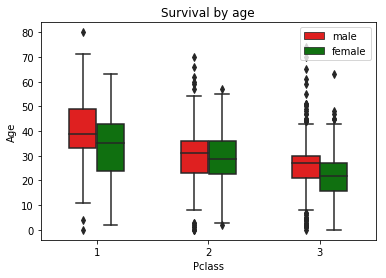

In [5]:
# Box plot
data_plot = train_df[train_df['Survived']==1]

colors = ['red', 'green', 'blue']
fig = plt.figure()
ax = sns.boxplot(x='Pclass', y='Age', data=train_df, hue='Sex', 
                 palette=sns.color_palette(colors), width=0.5)
plt.xlabel('Pclass')
l = plt.legend(loc=1)
l.get_texts()[0].set_text('male')
l.get_texts()[1].set_text('female')
plt.title('Survival by age')

Text(0.5, 1.0, 'Survival by age')

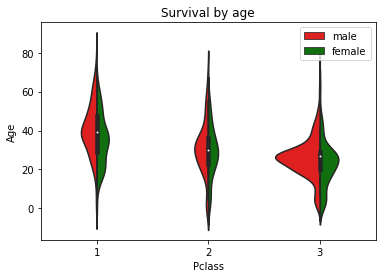

In [6]:
# Violin plot
data_plot = train_df[train_df['Survived']==1]

colors = ['red', 'green', 'blue']
fig = plt.figure()
ax = sns.violinplot(x='Pclass', y='Age', data=train_df, hue='Sex', 
                    palette=sns.color_palette(colors), split=True, 
                    scale='count', scale_hue=False)
plt.xlabel('Pclass')
l = plt.legend(loc=1)
l.get_texts()[0].set_text('male')
l.get_texts()[1].set_text('female')
plt.title('Survival by age')

Text(0.5, 0.98, 'Survival by age')

<Figure size 432x288 with 0 Axes>

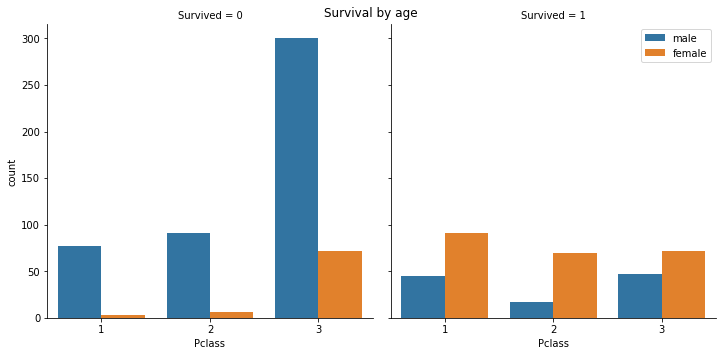

In [7]:
# Countplot
data_plot = train_df
fig = plt.figure()
ax = sns.catplot(x='Pclass', col='Survived', hue='Sex', data=train_df, kind='count', legend=False)
l = plt.legend(loc=1)
l.get_texts()[0].set_text('male')
l.get_texts()[1].set_text('female')
plt.suptitle('Survival by age')

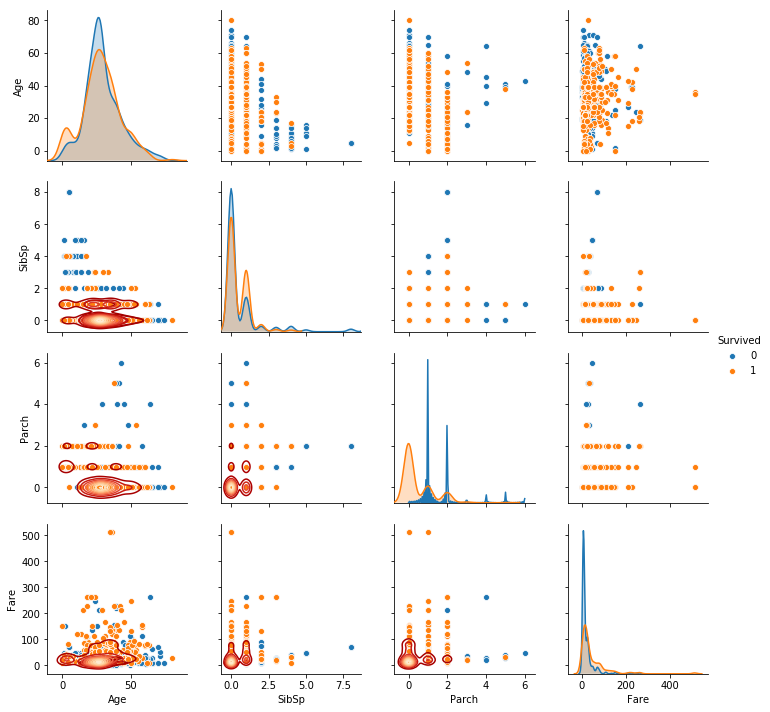

In [8]:
# Pairplot
data_plot = train_df
grid = sns.pairplot(data=data_plot, hue='Survived', vars = ['Age', 'SibSp', 'Parch', 'Fare'])
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

## Automated feature engineering

In [9]:
test_df = data_filled[['PassengerId', 'Sex']]

In [10]:
es = ft.EntitySet(id='Test')
es.entity_from_dataframe(entity_id='passengers', dataframe=data_filled, index='PassengerId')
es.entity_from_dataframe(entity_id='id', dataframe=test_df, index='PassengerId')
r_passenger_id = ft.Relationship(child_variable=es['passengers']['PassengerId'], parent_variable=es['id']['PassengerId'])
es = es.add_relationships([r_passenger_id])

In [11]:
es

Entityset: Test
  Entities:
    id [Rows: 891, Columns: 2]
    passengers [Rows: 891, Columns: 12]
  Relationships:
    passengers.PassengerId -> id.PassengerId

In [12]:
agg_primitives = ['min', 'max', 'mean', 'count', 'num_unique']
trans_primitives = ['day', 'year', 'numwords']

In [13]:
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'id',
                                       trans_primitives = trans_primitives,
                                       agg_primitives=agg_primitives, 
                                       max_depth = 2, features_only=False)

In [14]:
feature_matrix.head()

,Sex,MIN(passengers.Parch),MEAN(passengers.Fare),MEAN(passengers.Pclass),MIN(passengers.Fare),MIN(passengers.SibSp),NUM_UNIQUE(passengers.Ticket),NUM_UNIQUE(passengers.Name),MAX(passengers.Survived),MEAN(passengers.Parch),...,MAX(passengers.SibSp),MEAN(passengers.Age),NUM_UNIQUE(passengers.Cabin),NUM_UNIQUE(passengers.Embarked),NUM_UNIQUE(passengers.Sex),MAX(passengers.Pclass),MAX(passengers.Parch),MAX(passengers.Fare),MEAN(passengers.SibSp),MAX(passengers.Age)
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,male,0,7.2500,3,7.2500,1,1,1,0,0,...,1,22,0,1,1,3,0,7.2500,1,22
2,female,0,71.2833,1,71.2833,1,1,1,1,0,...,1,38,1,1,1,1,0,71.2833,1,38
3,female,0,7.9250,3,7.9250,0,1,1,1,0,...,0,26,0,1,1,3,0,7.9250,0,26
4,female,0,53.1000,1,53.1000,1,1,1,1,0,...,1,35,1,1,1,1,0,53.1000,1,35
5,male,0,8.0500,3,8.0500,0,1,1,0,0,...,0,35,0,1,1,3,0,8.0500,0,35


In [15]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [16]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [17]:
test = agg_numeric(train_df,'Pclass','test')
test.head()

,test_Survived_min,test_Parch_mean,test_SibSp_mean,test_Survived_mean,test_Survived_max,test_SibSp_max,test_Parch_max,test_Age_mean,test_Parch_sum,test_Age_max,test_Fare_mean,test_SibSp_sum,test_Survived_sum,test_Survived_count,test_Fare_max,test_Age_sum,test_Fare_sum
Pclass,,,,,,,,,,,,,,,,,
1,0,0.356481,0.416667,0.629630,1,3,4,38.222222,77,80,84.154687,90,136,216,512.3292,8256,18177.4125
2,0,0.380435,0.402174,0.472826,1,3,3,30.043478,70,70,20.662183,74,87,184,73.5000,5528,3801.8417
3,0,0.393075,0.615071,0.242363,1,8,6,24.959267,193,74,13.675550,302,119,491,69.5500,12255,6714.6951


In [18]:
test = agg_categorical(train_df,'Pclass','test')
test.head()

,test_Embarked_Q_mean,test_Embarked_C_mean,test_Sex_female_mean,test_Sex_male_mean,test_Embarked_S_mean,test_Embarked_Q_sum,test_Embarked_C_sum,test_Sex_female_sum,test_Sex_male_sum,test_Embarked_S_sum,test_Sex_female_count
Pclass,,,,,,,,,,,
1,0.009259,0.393519,0.435185,0.564815,0.597222,2,85,94,122.0,129.0,216
2,0.016304,0.092391,0.413043,0.586957,0.891304,3,17,76,108.0,164.0,184
3,0.146640,0.134420,0.293279,0.706721,0.718941,72,66,144,347.0,353.0,491


In [19]:
def agg_child(df, parent_var, df_name):
    """Aggregate a child dataframe for each observation of the parent."""
    
    # Numeric and then categorical
    df_agg = agg_numeric(df, parent_var, df_name)
    df_agg_cat = agg_categorical(df, parent_var, df_name)
    
    # Merge on the parent variable
    df_info = df_agg.merge(df_agg_cat, on = parent_var, how = 'outer')
    
    # Remove any columns with duplicate values
    _, idx = np.unique(df_info, axis = 1, return_index = True)
    df_info = df_info.iloc[:, idx]
    
    # memory management
    gc.enable()
    del df_agg, df_agg_cat
    gc.collect()
    
    return df_info

In [20]:
test = agg_child(train_df,'Pclass','test')
test.head()

,test_Survived_min,test_Embarked_Q_mean,test_Parch_mean,test_Embarked_C_mean,test_SibSp_mean,test_Sex_female_mean,test_Sex_male_mean,test_Embarked_S_mean,test_Survived_mean,test_Survived_max,...,test_Embarked_C_sum,test_SibSp_sum,test_Sex_female_sum,test_Sex_male_sum,test_Embarked_S_sum,test_Survived_sum,test_Survived_count,test_Fare_max,test_Age_sum,test_Fare_sum
Pclass,,,,,,,,,,,,,,,,,,,,,
1,0,0.009259,0.356481,0.393519,0.416667,0.435185,0.564815,0.597222,0.629630,1,...,85,90,94,122.0,129.0,136,216,512.3292,8256,18177.4125
2,0,0.016304,0.380435,0.092391,0.402174,0.413043,0.586957,0.891304,0.472826,1,...,17,74,76,108.0,164.0,87,184,73.5000,5528,3801.8417
3,0,0.146640,0.393075,0.134420,0.615071,0.293279,0.706721,0.718941,0.242363,1,...,66,302,144,347.0,353.0,119,491,69.5500,12255,6714.6951


## Model building

### Hyper parameter tuning with hyperopt

In [21]:
train = train_df.copy()
train['Sex'] = train_df['Sex'].map({'male':0, 'female':1}).astype(int)
train['Embarked'] = train_df['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

In [22]:
X_train = train.drop(columns=['Survived']).values
y_train = train_df['Survived'].values

In [23]:
params_grid = {'n_estimators': 100+hp.randint('n_estimators', 100),
              'num_leaves': 20+hp.randint('num_leaves',30),
              'min_child_samples': 10+hp.randint('min_child_samples', 10),
              'colsample_bytree': hp.uniform('colsample_by_tree', 0.8, 1.0),
              'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)}

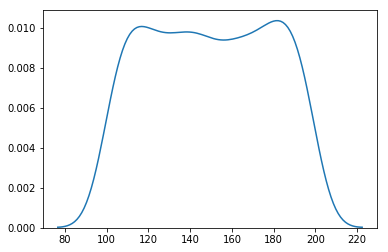

In [24]:
test_dist = []
for _ in range(1000):
    test_dist.append(sample(params_grid)['n_estimators'])
    
sns.kdeplot(test_dist)

In [25]:
x = sample(params_grid)

In [26]:
x

{'colsample_bytree': 0.9949325244006281,
 'min_child_samples': 18,
 'n_estimators': 115,
 'num_leaves': 38,
 'reg_lambda': 0.24751681969990247}

In [27]:
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

In [28]:
def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    clf_lgb = lgb.LGBMClassifier(n_jobs=4)
    clf_lgb.set_params(**hyperparameters)
    shuffle = StratifiedKFold(n_splits=5, shuffle=True)
    score = cross_val_score(clf_lgb, X_train, y_train, cv=shuffle, scoring='roc_auc', n_jobs=4)
    loss = 1-score.mean()
    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters,'status': STATUS_OK}

In [29]:
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin

tpe_algorithm = tpe.suggest
trials = Trials()

In [58]:
best = fmin(fn=objective, space=params_grid, algo=tpe_algorithm, trials=trials, max_evals=100)

In [59]:
from hyperopt import space_eval

param_values = [x['misc']['vals'] for x in trials.trials]
param_values = [{key:value for key in x for value in x[key]} for x in param_values]
param_values = [space_eval(params_grid, x) for x in param_values]

In [60]:
param_df = pd.DataFrame(param_values)
param_df['auc_score'] = [1-x for x in trials.losses()]
param_df.index.name = 'Iteration'

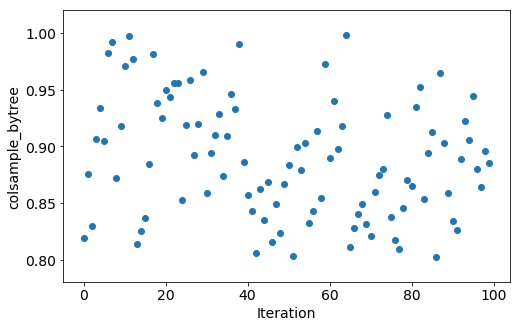

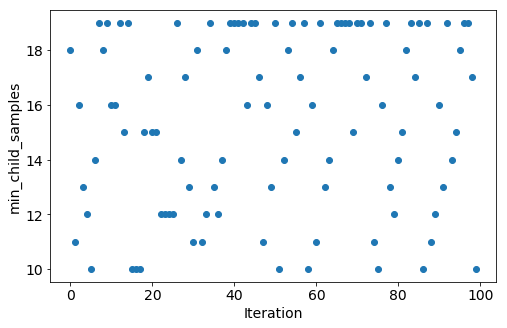

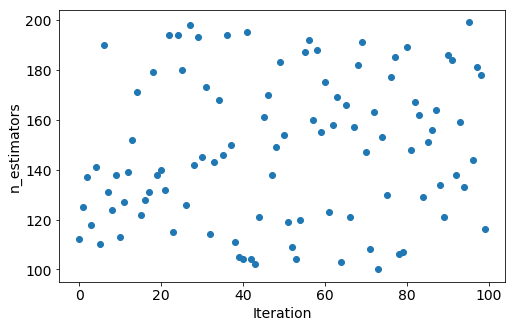

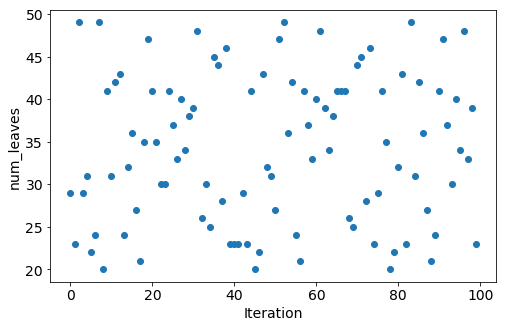

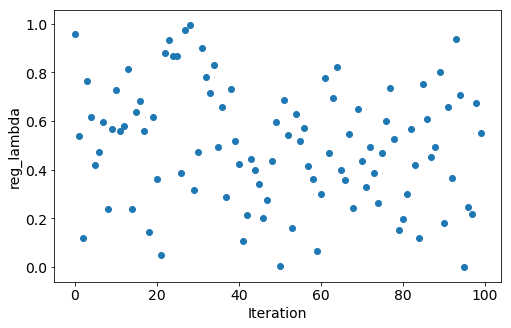

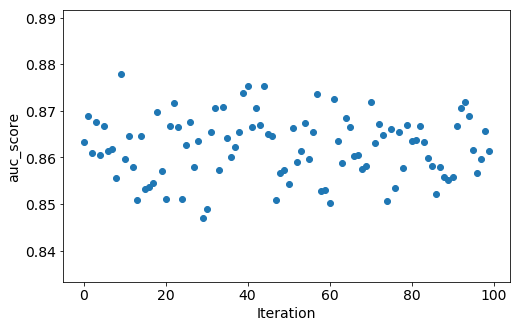

In [61]:
for column in param_df.columns:
    fig = plt.figure()
    plt.scatter(param_df.index, param_df[column])
    plt.xlabel('Iteration')
    plt.ylabel(column)

In [66]:
best_params = space_eval(params_grid, best)
print(best_params)

{'reg_lambda': 0.5692707062695207, 'n_estimators': 138, 'min_child_samples': 19, 'colsample_bytree': 0.9182329795783539, 'num_leaves': 41}


### Ensemble with mlxtend

In [72]:
clfs = []
folds = 8
for i in range(folds):
    clf_lgb = lgb.LGBMClassifier(random_state=i)
    clf_lgb.set_params(**best_params)
    clfs.append(clf_lgb)

lr = LogisticRegression() 
sclf = StackingClassifier(classifiers=clfs, use_probas=True, meta_classifier=lr)
eclf = EnsembleVoteClassifier(clfs=clfs, voting='soft')

In [49]:
for i in range(len(clfs)):
    scores = cross_val_score(clfs[i], X_train, y_train, cv=4, scoring='accuracy')
    print("Accuracy model %i: %0.3f" %(i+1, np.mean(scores)))

Accuracy model 1: 0.813
Accuracy model 2: 0.815
Accuracy model 3: 0.809
Accuracy model 4: 0.817
Accuracy model 5: 0.815
Accuracy model 6: 0.819
Accuracy model 7: 0.808
Accuracy model 8: 0.814


In [50]:
scores = cross_val_score(sclf, X_train, y_train, cv=4, scoring='accuracy')
print("Accuracy stacked model: %0.3f" %(np.mean(scores)))

Accuracy stacked model: 0.816


In [73]:
scores = cross_val_score(eclf, X_train, y_train, cv=4, scoring='accuracy')
print("Accuracy vote model: %0.3f" %(np.mean(scores)))

Accuracy vote model: 0.815


In [67]:
clfs = []
folds = 8
for i in range(folds):
    clf_lgb = lgb.LGBMClassifier(random_state=i)
    clf_lgb.set_params(**best_params)
    clfs.append(('lgbm%i'%i,clf_lgb))
    
vc = VotingClassifier(clfs, voting='soft')
scores = cross_val_score(vc, X_train, y_train, cv=4, scoring='accuracy')
print("Accuracy voting model: %0.3f" %(np.mean(scores)))

Accuracy voting model: 0.815
